# Naive Bayes i Classificació


En aquest tercer lliurament es programarà un classificador, que donat un tweet el categoritzarà en una de les possibles classes. En aquesta ocasió, implementareu un classificador amb tweets de polítics.


**Què s’ha de fer?**

Volem classificar tweets corresponents a diferents politics segons a quin partit polític pertanyen. 
A partir de tots els tweets que tenim, crearem un vector de característiques que ens descrigui cada un dels tweets. 
Finalment desenvoluparem un classificador probabilístic del tipus Naive Bayes que ens permeti identificar a quin partit polític pertany un tweet donat segons les característiques triades.


**Quina és la idea del sistema de classificació que s’ha de desenvolupar?**

El classificador és un concepte de l'aprenentatge automàtic supervisat. 
L'objectiu del classificador és donat un vector de característiques que descriuen els objectes que es volen classificar indicar a quina categoria o classe pertanyen d'entre un conjunt predeterminat. 
El procés de classificació consta de dues parts: 
(a) el procés d'aprenentatge i 
(b) el procés d'explotació o testeig. 
El procés d'aprenentatge rep exemples de parelles $(x,y)$ on $x$ són les característiques, usualment nombres reals, i $y$ és la categoria a la que pertanyen. 
Aquest conjunt se'l coneix com a conjunt d'entrenament i ens servirà per trobar una funció $\hat{y}=h(x)$ que donada una $x$ aconsegueixi que $\hat{y}=y$. Per altra banda el procés de testeig aplica la funció $h(x)$ apresa a l'entrenament a una nova descripció per veure quina categoria li correspon.


**Classificació i llenguatge natural**

La descripció dels exemples en característiques és el punt més crític de tot sistema d'aprenentatge automàtic. 
Una de les representacions més simples per tal de descriure un text és la representació *bag-of-words*.
Aquesta representació converteix un text en un vector de $N$ paraules. 
Consisteix en seleccionar un conjunt d'$N$ paraules i per cada paraula comptar quants cops apareix en el text. 
Una versió alternativa d'aquest procés pot ser simplement indicar si apareix o no en el text.

## Abans de començar


**\+ Durant la pràctica, solament es podran fer servir les següents llibreries**:

`Pandas, Numpy` i `NLTK`

*Nota: A més de les que ja es troben presents en la 1a cel·la i funcions natives de Python*

**\+ No es poden modificar les definicions de les funcions donades, ni canviar els noms de les variables i paràmetres ja donats**

Això no implica però que els hàgiu de fer servir. És a dir, que la funció tingui un paràmetre anomenat `df` no implica que l'hàgiu de fer servir, si no ho trobeu convenient.

**\+ En les funcions, s'especifica què serà i de quin tipus cada un dels paràmetres, cal respectar-ho**

Per exemple (ho posarà en el pydoc de la funció), `df` sempre serà indicatiu del `Pandas.DataFrame` de les dades. 

# Preparar les dades

In [1]:
import pandas as pd
import numpy as np
import nltk as nltk
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import zipfile
import pickle
from os.path import join as path, dirname

try:
    from IPython.core.display import HTML

    def pprint(df):
        with pd.option_context('display.max_rows', None, 'display.max_columns', None):
            display(HTML(pd.DataFrame(df).to_html()))
except:
    def pprint(df):
        print(df)

In [3]:
print('Training data')
df_tweets_train = pd.read_excel(path('data', 'train.xlsx'), index_col='Id')
pprint(df_tweets_train.head())
print(df_tweets_train.shape)

print('Test data')
df_tweets_test = pd.read_excel(path('data', 'test.xlsx'), index_col='Id')
pprint(df_tweets_test.head())
print(df_tweets_test.shape)

Training data


,username,party,text,created_at,retweet_count,favorite_count
Id,,,,,,
0,martarovira,erc,"Últim acte de campanya! Aquí tossudament alçats i amb un somriure per fer camí cap a la #República. Ho hem dit tan alt que l'Oriol @junqueras, avui, ens ha sentit des d'Estremera!",2017-12-19 20:12:01,785,2295
1,xavierdomenechs,comuns,"#Badalona necessita uns pressupostos que posin la ciutadania al capdavant i que segueixin recuperant els drets socials que les retallades del PP van eliminar. La transformació a Badalona no es pot aturar. Per això, tot el suport a @mariadolorsa. \n\n#DolorsAlcaldessa",2018-04-27 10:04:19,55,93
2,albert_rivera,cs,Encuentro Villacís-Valls para lanzar una estrategia electoral común en Madrid y Barcelona,2018-11-17 20:34:58,357,622
3,jaumecollboni,psc,"“La palabra es como una bala, no tiene retorno” interesante entrevista a ⁦@mcampovidal⁩",2018-10-22 18:10:01,4,6
4,albiol_xg,ppc,"📻 Esta noche, a partir de las 22:10h, me entrevistan en @linternacope. ¡Os espero!",2018-08-16 10:30:27,20,47


(1920, 6)
Test data


,text,retweet_count,favorite_count
Id,,,
0,"Avui hem représ la Comissió Mixta amb el @govern: entenem q ha estat un any difícil però necessitem q Generalitat assumeixi les seves obligacions en temes tan bàsics com habitatge, bressol, residències gent gran o llei de barris. BCN no pot esperar més:",67,103
1,"Torra anunció un ""otoño caliente"" para aumentar la tensión, el conflicto y la fractura social en Cataluña y ahora sus comandos separatistas pretenden bloquear las calles de Barcelona. Sánchez debe rectificar y defender a millones de catalanes ante los abusos del separatismo",856,1501
2,Demà cal sortir als carrers per dir que #BarcelonaNoEstaEnVenda.\n\nVolem uns lloguers i un habitatge digne. \n\nNo permetrem que venguin les ciutats als fons voltors i especuladors.,144,174
3,“Cercàvem or i vam baixar a la mina.\nI la foscor d’il·luminà de sobte\nperquè érem dos a contradir la nit” \n\nJoan Vinyoli,338,1560
4,"Molt senzill d'entendre, companya: \n1.- L'ALLIBERAMENT de dues persones innocents i honrades!\n2.- LA LLIBERTAT: que no se'ns imposi el que hem de pensar i fer!\n3.- REBUTJAR les amenaces, els tribunals, els fiscals i la policia al vostre servei per a fer oposició! \nSí, seny!",4932,7253


(480, 3)


# Implementació

Dividirem el notebook en 3 seccions que es complementen una a l'altra:

1. Anàlisis de dades: Informació bàsica sobre els tweets
2. Processament de les dades: Creació d'un vector de característiques a partir dels tweets
3. Classificació amb Naive Bayes

### Anàlisis de dades

El primer que haurem de fer és analitzar les dades mitjançant diferents funcions.

In [4]:
def count_tweets(df):
    """
    Retorna el número de tweets en el dataframe
    
    :param df: DataFrame amb els tweets i la informació associada
    :return : número de tweets
    """
    return df.shape[0]

def get_politicians(df):
    """
    Retorna els usuaris dels polítics que han tuitejat
    
    :params df: DataFrame amb els tweets i la informació associada
    :return : Llista de strings amb els nom dels usuaris
    """
    return df['username'].unique()

def count_politicians(df):
    """
    Retorna la quantitat de polítics que han tuitejat
    
    :params df: DataFrame amb els tweets i la informació associada
    :return : Enter amb la quanitat d'usuaris que han tuitejat
    """
    return len(get_politicians(df))

def get_political_party(df):
    """
    Retorna els partits polítics que han tuitejat
    
    :params df: DataFrame amb els tweets i la informació associada
    :return : Llista de strings amb els nom dels partits polítics que han tuitejat
    """
    return df['party'].unique()

def count_political_party(df):
    """
    Retorna la quantitat de partits polítics que han tuitejat
    
    :params df: DataFrame amb els tweets i la informació associada
    :return : Enter amb la quanitat d'usuaris que han tuitejat
    """
    return len(get_political_party(df))

def count_tweet_politician(df):
    """
    Retorna la quantitat de tweets per polític
    
    :params df: DataFrame amb els tweets i la informació associada
    :return : pd.Series amb la quantitat de tweets per polític
    """
    return df['username'].value_counts()

def count_tweet_party(df):
    """
    Retorna la quantitat de tweets per partit polític
    
    :params df: DataFrame amb els tweets i la informació associada
    :return : pd.Series amb la quantitat de tweets per partit polític
    """
    return df['party'].value_counts()

def top_retweet(df, n):
    """
    Retorna els n tweets que han sigut més retuitejats
    
    :params df: DataFrame amb els tweets i la informació associada
    :params n: número de tweets per veure
    :return : pd.Series amb els top retweets
    """
    return df.nlargest(n, columns='retweet_count')['text']
    
def top_favorite(df, n):
    """
    Retorna els n tweets més favorits
    
    :params df: DataFrame amb els tweets i la informació associada
    :params n: número de tweets per veure
    :return : pd.Series amb els top favorits
    """
    return df.nlargest(n, columns='favorite_count')['text']

1920
['martarovira' 'xavierdomenechs' 'albert_rivera' 'jaumecollboni'
 'albiol_xg' 'miqueliceta' 'quimtorraipla' 'adacolau' 'santirodriguez'
 'krls' 'joantarda' 'inesarrimadas'] 12
['erc' 'comuns' 'cs' 'psc' 'ppc' 'jxcat'] 6


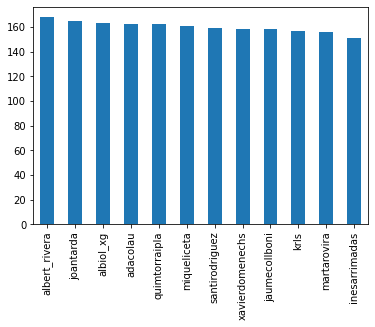

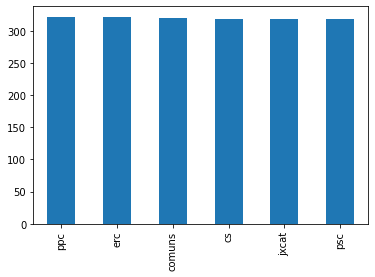

,text
Id,
907,"Que una republicana defienda la República es bastante previsible. De quien cuesta fiarse es de un republicano francés que de repente se vuelve monárquico. Liberté, egalité, fraternité... se quedaron en los Pirineos?"
781,A tots els demòcrates: no pararem fins que tornin a casa!#LlibertatPresosPolítics
138,"Una causa que necessiti ser defensada amb cúters i cops de puny a periodistes (telemadrid i jordi borràs) és ben trista i no té futur, encara que tingui impunitat, diners i rei. Ho dèiem fa uns dies: l'aporellos se'ls està anant de les mans."
1664,".@junqueras President d'un partit amb 86 anys d'història sense cap cas de corrupció, és a la presó per instància del partit més corrupte d'Europa: el PP. I els seus imputats, on són? Esquiant, recol•locats a l'Ibex, i es veu que no troben un tal M. Rajoy \nEl 21D, fem justícia!"
1515,"Perdoneu, però això és tan greu que si no hi ha conseqüències, el sistema judicial espanyol de la monarquia farà aigües definitivament. En mans de qui està un dels pilars de tot sistema democràtic?"


,text
Id,
907,"Que una republicana defienda la República es bastante previsible. De quien cuesta fiarse es de un republicano francés que de repente se vuelve monárquico. Liberté, egalité, fraternité... se quedaron en los Pirineos?"
138,"Una causa que necessiti ser defensada amb cúters i cops de puny a periodistes (telemadrid i jordi borràs) és ben trista i no té futur, encara que tingui impunitat, diners i rei. Ho dèiem fa uns dies: l'aporellos se'ls està anant de les mans."
174,Acabo d'arribar a #Escòcia convidat pel Fòrum diplomàtic @BeyondBorders__ per explicar el conflicte català. Reprenem l’activitat internacional per lluitar per la llibertat de la #RepúblicaCatalana
781,A tots els demòcrates: no pararem fins que tornin a casa!#LlibertatPresosPolítics
1043,"Una gran #Diada2018 per avançar cap a la república. No hi ha cap altre poble a Europa que hagi mobilitzat tants milions de persones, set anys seguits i sense incidents. Demanem votar el nostre futur i ser respectats com a nació. Gràcies a tots els qui ho esteu fent possible!"


In [5]:
print(count_tweets(df_tweets_train))
print(get_politicians(df_tweets_train), count_politicians(df_tweets_train))
print(get_political_party(df_tweets_train), count_political_party(df_tweets_train))

count_tweet_politician(df_tweets_train).plot.bar()
plt.show()

count_tweet_party(df_tweets_train).plot.bar()
plt.show()

pprint(top_retweet(df_tweets_train, 5))
pprint(top_favorite(df_tweets_train, 5))


### Comptar paraules

El primer que haurem d'implementar és la funció *normalize* que normalitzarà les paraules.

No modificar la següent cel·la, s'encarrega de guardar una caché de la funció normalize per accelerar el procés.

In [6]:
def memo(f):
    class memodict(dict):
        def __init__(self, f):
            self.f = f
        def __call__(self, *args):
            return self[args]
        def __missing__(self, key):
            ret = self[key] = self.f(*key)
            return ret
        
    return memodict(f)

In [9]:
#Funcio creada per nosaltres per eliminar els accents i les dieresis d'una paraula
def remove_accents_and_diaeresis(word):
    """
    Retorna la paraula word sense accents ni dieresis.
    Per exemple, si word = 'hölàié' retorna 'holaie'.
    
    :param word: paraula de la qual s'han de treure els accents i les dieresis.
    :return : String amb la paraula sense accents ni dieresis.
    """
    
    result = ''
    for ch in word:
        if (ch =='á' or ch =='à' or ch =='ä'):
            result += 'a'
        elif (ch =='é' or ch =='è' or ch =='ë'):
            result += 'e'
        elif (ch =='í' or ch =='ì' or ch =='ï'):
            result += 'i'
        elif (ch =='ó' or ch =='ò' or ch =='ö'):
            result += 'o'
        elif (ch =='ú' or ch =='ù' or ch =='ü'):
            result += 'u'
        else:
            result += ch
    return result

#Funcio creada per nosaltres per eliminar els apostrofs inicials i finals d'una paraula 
def remove_apostrophes(word):
    """
    Retorna la paraula word sense apostrofs.
    Per exemple, si word = "l'Anna" retorna "Anna".
                 si word = "veure'l" retorna "veure".
    
    :param word: paraula de la qual s'han de treure els apostrofs.
    :return : String amb la paraula sense apostrofs.
    """
    #Fem un try perque tambe es possible que despres de l'apostrof s'acabi la paraula.
    #Per exemple podria ser que word fos "l'", en aquest cas es retornaria "l'".
    try:
        if (word[1] == "'"):
            word = word[2:]
        if (word[len(word)-2] == "'"):
            word = word[:-2]
    except: 
        return word
    return word

@memo
def normalize(word):
    """
    Funció que donada una paraula la normalitzi
    Exemple: inFO*RmÀ745tica? ---> informatica
    
    :param word: paraula a normalitzar
    :return : paraula normalitzada
    """
    #Eliminem els apostrofs de la paraula
    word = remove_apostrophes(word)
    #Eliminem tots els caracters de la paraula que no son lletres
    word = ''.join([ch for ch in word.lower() if ch.isalpha()])
    #Eliminem els accents i les dieresis de la paraula
    word = remove_accents_and_diaeresis(word)
    return word

normalize('inFO*RmÀ745tica')

'informatica'

In [10]:
def sentence_to_words(sentence):
    """
    Funció que donada una frase, generi una llista amb totes les seves paraules normalitzades.
    
    :param sentence: frase a transformar
    :return : llista de paraules (no buides) normalitzades
    
    Exemple: **Taller DELS noUS U**SOS    de la inFO#Rm765Àtica? ---> 
        ['taller', 'dels', 'nous', 'usos', 'de', 'la', 'informatica']
    """
    #Retornem una llista amb les paraules normalitzades i filtrem la llista perque no hi hagin paraules 'buides'
    return list(filter(lambda word: word != '', [normalize(word) for word in sentence.split()]))

sentence_to_words('**Taller DELS noUS U**SOS    de la inFO#Rm765Àtica?')

['taller', 'dels', 'nous', 'usos', 'de', 'la', 'informatica']

In [11]:
def count_words(df):
    """
    Funció que ha de construir un DataFrame amb índex les paraules normalitzades,
    i columnes n_ocur (nombre de vegades que apareix la paraula a tots els tweets)
    i n_tweets (nombre de tweets on apareix la paraula alguna vegada).
    
    :param df: DataFrame amb els tweets i la informació associada
    :return : DataFrame especificat.
    """
    #Obtenim un pd.Series amb els tweets normalitzats
    normalized = df['text'].apply(sentence_to_words)
    #Obtenim un DataFrame on les files son els index dels tweets, les columnes
    #son les paraules normalitzades i l'element de la posicio [i,j] es el nombre
    #de vegades que la paraula j apareix al tweet i. (Quan una paraula apareix 0 cops, el valor es NaN)
    occurrences = normalized.apply(pd.Series.value_counts)
    #Obtenim un pd.Series amb el nombre de vegades que cada paraula apareix a tots els tweets
    n_ocur = occurrences.sum(axis=0).astype(int)
    #Obtenim un pd.Series amb el nombre de tweets on apareix cada paraula alguna vegada
    n_tweets = occurrences.notna().sum(axis=0)
    #Concatenem els 2 pd.Series per obtenir el DataFrame a retornar
    result = pd.concat([n_ocur, n_tweets], axis=1)
    
    #Reanomenem les columnes i l'index
    result.columns = ['n_ocur', 'n_tweets']
    result.index.names = ['words']
    
    return result

In [12]:
counts = count_words(df_tweets_train)

counts.head()

,n_ocur,n_tweets
words,,
des,49,46
hem,107,100
cap,68,60
tossudament,2,2
alt,4,4


### Contar paraules per partit polític

In [13]:
def count_words_parties(df):
    """
    Funció que ha de construir un DataFrame amb columnes les paraules normalitzades,
    i índex cadascún dels partits, contenint el nombre de vegades que cada paraula
    ha aparegut a tweets del partit.
    
    :param df: DataFrame amb els tweets i la informació associada
    :return : DataFrame esmentat.
    """
    
    #Creem una copia del DataFrame original per no modificar-lo
    df_copy = df.copy()
    #A la columna 'text' hi posem els tweets normalitzats
    df_copy['text'] = df_copy['text'].apply(sentence_to_words)
    
    #Obtenim un DataFrame on les files son els indexs dels tweets, les columnes
    #son les paraules normalitzades i l'element de la posicio [i,j] es el nombre
    #de vegades que la paraula j apareix al tweet i. (Quan una paraula apareix 0 cops, el valor es NaN)
    occurrences = df_copy['text'].apply(pd.Series.value_counts)
    #Canviem els indexs del DataFrame occurrences pel nom del partit al qual pertany cada tweet
    occurrences.index = df_copy['party']
    
    #Retornem un DataFrame amb les columnes les paraules normalitzades i index cadascun dels partits,
    #contenint el nombre de vegades que cada paraula ha aparegut a tweets del partit
    return occurrences.groupby(level=0).sum().astype(int)

words_parties = count_words_parties(df_tweets_train)
words_parties.head()

,des,hem,cap,tossudament,alt,somriure,avui,cami,tan,la,...,nefastas,conocian,siguieron,acumulan,aceleracion,bienal,malestares,desplazando,contemporaneo,incertidumbres
party,,,,,,,,,,,,,,,,,,,,,
comuns,10,26,15,0,0,2,55,7,6,491,...,0,0,0,1,1,1,1,1,1,1
cs,2,2,0,0,0,0,4,0,2,400,...,1,1,1,0,0,0,0,0,0,0
erc,17,24,27,2,1,1,53,7,14,409,...,0,0,0,0,0,0,0,0,0,0
jxcat,13,34,19,0,2,2,34,6,4,442,...,0,0,0,0,0,0,0,0,0,0
ppc,0,3,2,0,1,1,11,1,0,299,...,0,0,0,0,0,0,0,0,0,0


### Paraules més freqüents als tweets


**El problema de com escollir el vector de carecterístiques**

L'elecció de les paraules que formen el vector de característiques és un pas crític. 
En funció de com de bona sigui aquesta descripció, millor funcionarà el sistema. 
Tot i que us deixem a vosaltres la política de creació del vector de característiques us donem una d'exemple. 
Per saber quines paraules fer servir una possible estratègia és agafar aquelles paraules que apareixen entre en un 10 i un 50 percent del total (sense tenir en compte el partit). 
Podeu experimentar variant aquests valors.

In [14]:
skip_words = [
                "a", "de", "la", "el", "que", "una", "va", 
                "un", "i", "y", "per", "els", "les", "com",
                "en", "del", "no", "es", "amb", "al", "hi",
                "", "q", "d", "los", "las", "dels", "o", 
                "lo", "los", "para", "con", "ens", "ha",
                "se", "esta", "como", "the", "su", "si",
                "por", "mes", "mas", "hem",
                "tot", "tots", "als", "fer", "he", "han", 
                "us", "van", "pel", "me", "of", "nos", "to",
                "aquest", "molt", "sobre", "x", 
                "h", "e", "ni", "pero"
            ]

# depèn de vosaltres emplenar aquesta llista amb possibles paraules a excloure

In [19]:
def topNwords(df, words, N, skip=[]):
    """
    Funció que crea un pd.Series amb índex cadascún dels partits,
    i values una llista de les N paraules més representatives 
    (les que apareixen amb més freqüència) de cadascún dels partits polítics.
    
    :param df: DataFrame amb els tweets i la informació associada
    :param words: diccionari amb les paraules i la seva frequencia
    :param N: número de paraules més representatives que volem considerar
    :return : pd.Series resultant.
    """
    #Prenem nomes les paraules que ens interessen. Es a dir, eliminem les columnes
    #corresponents a paraules que es troben a skip words
    words_filtered = words.copy()
    words_filtered = words_filtered.drop(skip, axis=1, errors='ignore')
    #Ordenem les paraules per a cada partit segons el nombre de cops que apareixen a tweets del partit
    ordered = words_filtered.apply(lambda row: sorted(pd.Series(zip(words_filtered.columns, row)),
                                                      key=lambda cv: cv[1], reverse=True), axis=1)
    #Prenem nomes les paraules i no els valors i ens quedem amb les N millors paraules per a cada partit
    ordered = ordered.apply(lambda cell: np.array([x[0] for x in cell][:N]))
    return ordered
    
top_words = topNwords(df_tweets_train, words_parties, 10, skip_words)

De cara a millores, tingueu en compte que també haureu de filtrar aquelles paraules que apareixen en la majoria  de tweets, així com també, les que únicament apareixen en un conjunt molt petit de tweets.

### Vector de Característiques
Creeu el vector de característiques necessari per a fer l’entrenament del Naïve Bayes

In [27]:
def create_features(df, top_words): 
    """
    Funció que crea un vector de característiques necessari per a l'entrenament del classificador Naive Bayes.
    Retorna un DataFrame on cada fila representa el vector de característiques del corresponent tweet.
    
    :params df: DataFrame amb els tweets i la informació associada
    :params top_words: ha de ser el pd.Series que retorna topNWords
    :return : pd.DataFrame resultant.
    """
    #Prenem una llista amb totes les paraules presents al pd.Series top_words
    words = np.array(top_words.explode())
    #Si hi ha paraules repetides, ens quedem nomes amb una copia
    words = np.unique(words)
    
    #Obtenim un pd.Series amb els tweets normalitzats
    normalized = df['text'].apply(sentence_to_words)
    
    #Definim la funcio f per aplicar a cada tweet normalitzat
    f = lambda cell: [x in cell for x in words]
    #Obtenim un pd.Series amb el vector de caracteristiques de cada tweet
    features = normalized.apply(f)
    
    #Convertim els vectors de caracteristiques a DataFrame i els retornem
    return pd.DataFrame(features.tolist(), index=features.index, columns=words)

In [29]:
N = 10 # Aquest parametre el podem canviar i fer proves per avaluar quin és el millor valor.

words_parties = count_words_parties(df_tweets_train)
top_words = topNwords(df_tweets_train, words_parties, N, skip_words)
features = create_features(df_tweets_train, top_words)

### El classificador Naïve Bayes

Un cop tenim una representació necessitem un procés d'aprenentatge que ens permeti passar de la descripció a una categoria. 
En aquest lliurament farem servir el classificador Naïve Bayes. 
Aquest classificador forma part de la família de classificadors probabilístics. 
La sortida d'un classificador probabilístic és un valor de probabilitat donat un exemple per cadascuna de les categories. 
La decisió final correspon a la categoria amb més probabilitat. 


Els classificadors probabilistics Bayesians es basen en el teorema de Bayes per realitzar els càlculs per trobar la probabilitat condicionada: 
$$ p(x,y) = p(x|y)p(y) = p(y|x)p(x)$$
d'on podem extreure que: 
$$ p(y|x) = \frac{p(x|y)p(y)}{p(x)}$$


En molts casos $p(y)$ i $p(x)$ són desconeguts i es consideren equiprobables. 
Per tant, la decisió es simplifica a:
$$ p(y|x) = c · p(x|y)$$


Les deduccions fins a aquest punt són vàlides per la majoria de classificadors Bayesians. 
Naïve Bayes es distingeix de la resta perquè imposa una condició encara més restrictiva. 
Considerem $x=(x_1, \cdots, x_n)$ un conjunt d'$N$ variables aleatòries. 
Naïve Bayes assumeix que totes elles són independents entre elles i per tant podem escriure:
$$p(x_1,x_2,...,x_N | y) = p(x_1|y)p(x_2|y)...p(x_N|y)$$


Podem interpretar l'anterior equació de la següent forma: La probabilitat de que el tweet descrit pel vector de característiques (0,1,0,1,1,1) sigui de la classe "comuns" és proporcional al producte de la probabilitat que la primera paraula del vector no aparegui en els tweets sobre "comuns"  per la probabilitat que la segona paraula sí que hi aparegui, etc.


**Estimant les probabilitats marginals condicionades**

L'últim pas que ens queda és trobar el valor de les probabilitats condicionades. 
Farem servir la representació de $0$'s i $1$'s indicant que la paraula no apareix (0) o sí apareix (1) a al tweet. 
Per trobar el valor de la probabilitat condicionada farem servir una aproximació freqüentista a la probabilitat. 
Això vol dir que calcularem la freqüència d'aparició de cada paraula per a cada categoria. 
Aquest càlcul es fa dividint el nombre de tweets de la categoria en que apareix la paraula pel nombre total de tweets d'aquella categoria. 

En general:
$$p(x = \text{"badalona"} | y = C)= \frac{A}{B} $$
on A és el número de tweets de la categoria C on hi apareix la paraula 'badalona' i B és el número total de tweets de la categoria C.


### Punts dèbils:

**El problema de la probabilitat 0**

Si us hi fixeu bé, la probabilitat pot ser 0 !! 
Això vol dir, que si en el tweet no hi apareix una paraula no pot ser classificada com un partit polític.
No sembla raonable que s'assigni o no en aquesta categoria segons si en el tweet hi apareix o no una única paraula. 
Per tant, el que s'acostuma a fer és donar una baixa probabilitat en comptes de zero. 
Una de les possibles solucions es fer servir la correcció de Laplace. 
Seguint l'exemple anterior la correcció de Laplace és
$$p(x= \text{"badalona"} | y = 'C' ) = \frac{A+1}{B+M}$$ 
on M és el nombre de categories

**El problema del "underflow"**

La funció que hem de calcular en el Naive Bayes és un producte. 
El nombre de caractéristiques del vector és el nombre de termes del producte. 
Aquests nombres són iguals o menors a 1, si els multipliquem tots entre ells el resultat serà massa petit per a representar-lo en un nombre de punt flotant i el càlcul acabarà sent reduït a zero. 
Per solucionar aquest problema en comptes d'operar fent multiplicacions, se sol passar a l'escala logarítmica i allà operar fent servir sumes en comptes de multiplicacions.

### Classificar:

Donat un vector de característiques $x=(x_1,...,x_n)$, per classificar el que farem serà calcular la probabilitat de pertànyer a cada un dels partits polítics:

$$p(\text{comuns}|x) = p(\text{comuns})\prod_{i=1}^np(x_i|\text{comuns})$$
$$\cdots$$
$$p(\text{psc}|x) = p(\text{psc})\prod_{i=1}^np(x_i|\text{psc})$$

I finalment, el tweet és del partit de probabilitat màxima. Tingues en compte que per $x_i = 0$ s'ha de considerar la probabilitat inversa, és a dir, la probabilitat de ser de la clase $C$ quan $x_i = 0$ ve donada per $1 - p(x_i|C)$

Implementeu la funció d'aprenentatge del classificador Naïve Bayes (funció **naive_bayes_learn()**). La funció ha de mostrar per pantalla el resultat obtingut 
L'**error d'entrenament** es troba calculant el percentatge d'errors que s'obtenen quan es fa el testeig amb les mateixes dades utilizades per fer entrenament (aprenentatge). Aquest error es un valor molt optimista de com funcionarà el clasificador i mai s'ha de prendre com a mesura per comparar clasificadors. 

In [30]:
#Funcio creada per nosaltres per comptar el nombre de tweets de cada partit on apareix cada paraula
#Hem creat aquesta funcio per utilitzar-la des de la funcio naive_bayes_learn
def count_words_tweet_parties(df):
    """
    Funció que retorna un DataFrame amb columnes les paraules normalitzades,
    i índex cadascún dels partits, contenint el nombre de tweets de cada partit on
    ha aparegut cada paraula. A diferencia de count_words_parties(), en aquest cas si
    una paraula apareix dues vegades a un mateix tweet nomes es compta una sola vegada,
    mentre que en la funcio count_words_parties() es compta dues vegades.
    
    :param df: DataFrame amb els tweets i la informació associada
    :return : DataFrame esmentat.
    """
    #Creem una copia del DataFrame original per no modificar-lo
    df_copy = df.copy()
    #Obtenim un pd.Series amb els tweets normalitzats
    normalized = df_copy['text'].apply(sentence_to_words)
    #Canviem els indexs del pd.Series normalized pel nom del partit al qual pertany cada tweet
    normalized.index = df_copy['party']
    
    #Obtenim un DataFrame on les files son els noms dels partits al qual pertany cada tweet, les columnes
    #son les paraules normalitzades i l'element de la posicio [i,j] es el nombre
    #de vegades que la paraula j apareix al tweet i. (Quan una paraula apareix 0 cops, el valor es NaN)
    occurrences = normalized.apply(pd.Series.value_counts)
    #Retornem el nombre de tweets de cada partit on apareix cada paraula
    return occurrences.notna().groupby(level=0).sum().astype(int)

In [31]:
test = count_words_tweet_parties(df_tweets_train)
test

,des,hem,cap,tossudament,alt,somriure,avui,cami,tan,la,...,nefastas,conocian,siguieron,acumulan,aceleracion,bienal,malestares,desplazando,contemporaneo,incertidumbres
party,,,,,,,,,,,,,,,,,,,,,
comuns,10,23,13,0,0,2,55,6,5,241,...,0,0,0,1,1,1,1,1,1,1
cs,2,2,0,0,0,0,3,0,2,215,...,1,1,1,0,0,0,0,0,0,0
erc,16,23,22,2,1,1,52,6,13,216,...,0,0,0,0,0,0,0,0,0,0
jxcat,12,33,18,0,2,2,33,6,4,228,...,0,0,0,0,0,0,0,0,0,0
ppc,0,3,2,0,1,1,11,1,0,180,...,0,0,0,0,0,0,0,0,0,0
psc,6,16,5,0,0,0,28,1,0,213,...,0,0,0,0,0,0,0,0,0,0


In [35]:
def naive_bayes_learn(df, feats):
    """
    Funció que estima les probabilitats marginals condicionades.
    
    :params df: DataFrame amb els tweets i la informació associada (atribut party)
    :params feats: DataFrame de features de cada tweet.
    :return : DataFrame amb les probabilitats marginals condicionades amb la correcció de Laplace,
        on files són les feature words, i columnes són els partits.
    """
    #Calculem el nombre de tweets de cada partit on apareix cada paraula
    words_parties = count_words_tweet_parties(df)
    #Calculem el nombre de tweets que ha fet cada partit
    count_tweets_parties = count_tweet_party(df)
    #Calculem el nombre de partits politics
    num_parties = count_political_party(df)
    
    #Eliminem del DataFrame words_parties totes les columnes (i.e. paraules) que no son en feats
    result = words_parties[feats.columns]
    #Definim la funcio f a aplicar al DataFrame (corresponent a la probabilitat amb la correccio de Laplace)
    f = lambda row: (1 + row) / (count_tweets_parties[row.index] + num_parties)
    #Calculem les probabilitats marginals condicionades amb la correcció de Laplace
    result = result.apply(f)
    #Retornem el resultat transposat per retornar a les files les feature words i a les columnes els partits
    return result.T

In [36]:
def split_train_test(df, split):
    """
    Funció que separa les dades en training i test
    
    :param df:
    :param split: proporció de les dades que seràn per l'entrenament
    :return : retorna dos dataframes corresponents a l'entrenament i al test
    """
    assert split <= 1, 'split must be between 0 and 1'
    
    row = round(df.shape[0]*split)
    #Utilitzem les primeres files (split*100 % de files) per a train
    df1 = df.iloc[:row]
    #Utilitzem les ultimes files ((1-split)*100 % de files) per a test
    df2 = df.iloc[row:]
    return df1, df2

In [37]:
def naive_bayes(df_train, feat_train, feat_test, df_test=None):
    """
    Funció que implementa el clasificador Naive_Bayes, és a dir entrena amb les
    característiques d'entrenament i després utilitza les probabilitats estimades
    per classificar els vectors de test, segons la fórmula
    p(C_j|x) = p(C_j) * p(x_1|C_j) * ... * p(x_n|C_j)
    i agafant la màxima.
    
    Tingues en compte el problema de l'underflow:
    log(p(C_j|x)) = log(p(C_j) * p(x_1|C_j) * ... * p(x_n|C_j)) =
                  = log(P(C_j)) + log(p(x_1|C_j)) + ... + log(p(x_n|C_j))
                  
    I recorda, per x_i = 0 cal considerar 1 - p(x_1|C_j).
    
    Si df_test no és None, ha de calcular l'encert sobre les dades de test. És a dir,
    després de classificar feat_test ha de comparar la classificació amb la classe
    real i dir (print) quin percentatge d'encert ha obtingut.
    
    :param df_train: DataFrame amb els tweets que s'utilitzaran per l'entrenament
    :param feat_train: Diccionari amb els vectors de caracteristiques de cada tweet de l'entrenament
    :param feat_test: Diccionari amb els vectors de caracteristiques de cada tweet de test
    :param df_test: En cas d'estar disponible (per Kaggle no hi és), 
        DataFrame amb els tweets que s'utilitzaran pel test
    
    :return : Una serie on l'index correspon amb els indexos de df_test i els valors són la
        classificació retornada per Naive Bayes
    """
    #Calculem les probabilitats marginals condicionades amb la correccio de Laplace
    learn = naive_bayes_learn(df_train, feat_train)
    #Prenem els partits politics
    parties = get_political_party(df_train)
    #Prenem la quantitat de tweets que ha fet cada partit politic
    num_tw_partits = count_tweet_party(df_train)
    #Calculem la probabilitat que un tweet sigui d'un cert partit (en aquest cas no ens cal utilitzar
    #la correccio de Laplace perque la probabilitat que un tweet sigui d'un partit sempre sera diferent
    #de zero)
    prob_parties = num_tw_partits / (count_tweets(df_train))
    
    #A continuacio, calculem els logaritmes de les probabilitats, per evitar el problema de l'"underflow"
    #Calculem el logaritme de la probabilitat de cada partit
    prob_parties = np.log(prob_parties)
    #Calculem el logaritme de la probabilitat que cada paraula apareixi a un tweet de cada partit
    prob_yes = np.log(learn)
    #Calculem el logaritme de la probabilitat que cada paraula no apareixi a un tweet de cada partit
    prob_no = np.log(1-learn)
    
    #Calculem la probabilitat que cada tweet de test sigui de cada partit
    col = [
        (prob_parties[party] + (feat_test*prob_yes[party]).sum(axis=1) +
         ((~feat_test)*prob_no[party]).sum(axis=1)).tolist() for party in parties
    ]
    #Creem un pd.Series on l'index correspon amb els indexos de df_test i els valors són la
    #classificacio retornada per Naive Bayes
    results = pd.DataFrame(
        col, columns = feat_test.index, index=parties
    ).T.idxmax(axis=1)
    
    #Si df_test no es None, retornem el percentatge d'encerts
    if (df_test is not None):
        encerts = (df_test['party'] == results).sum()
        total = df_test.shape[0]
        print("Percentatge d'encerts: {}/{} = {} %".format(encerts, total, (encerts/total)*100))
        
    return results

In [38]:
df_train, df_test = split_train_test(df_tweets_train, 0.8)
N = 100 # Aquest parametre el podem canviar i fer proves per avaluar quin és el millor valor. 
words_topics = count_words_parties(df_train)
top_words = topNwords(df_train, words_topics, N, skip_words)

feat_train = create_features(df_train, top_words)
feat_test = create_features(df_test, top_words)

preds = naive_bayes(df_train, feat_train, feat_test, df_test)
    
preds.head()

Percentatge d'encerts: 246/384 = 64.0625 %


Id
1536        cs
1537     jxcat
1538    comuns
1539       erc
1540       psc
dtype: object

# Kaggle

### Nota
El codi que ens ha generat la millor puntuació al Kaggle l'hem guardat al Notebook anomenat TestsKaggle.ipynb

https://www.kaggle.com/t/ef3079700f9e49609ff7a2e70c6fc97e

In [22]:
words_topics = count_words_parties(df_tweets_train)
N = 200
top_words = topNwords(df_tweets_train, words_topics, N, skip_words)

feat_train = create_features(df_tweets_train, top_words)
feat_test = create_features(df_tweets_test, top_words)

result = naive_bayes(df_tweets_train, feat_train, feat_test)
result.index.name = 'tweet_id'
result.name = 'party'
result.to_frame().to_csv('submission.csv')
pprint(result.head())

,party
tweet_id,
0,comuns
1,cs
2,comuns
3,jxcat
4,jxcat
